## Chapter 9: Algorithm Analysis (Updated Oct. 5)

*Definition*: Consider two functions $f$ and $g$. We say that $f(n)$ is $O(g(n))$ or “big-O” of $g(n)$ if

$$ \lim_{n \rightarrow \infty} f(n) = C$$

for some $0<C<\infty$

Find big-O for the following:
* $n^2+e^n$
* $3n^2+e^{-n}$
* $n + n \ln (n)$

### Polynomial Evaluation

Recall that a polynomial is

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

For example, a quadratic is a polynomial like $q(x)= 3x^2+7x-2$

The simple way to evaluate the polynomial is to find each power of x and then multiply by the coefficient.  Here's a function that takes an array of coefficients and a value $x$ and calculates $p(x)$.  

In [2]:
function polyEval(coeffs::Vector{T}, x::S) where {T <: Number, S <: Number}
  local sum = zero(T)
  
  # we will use a simple power function that is not very efficient:
  function pow(x::T,n::Int) where T <: Number
    local prod = one(T)
    for j=1:n
      prod *=x
    end
    prod
  end
    
  # then we have the sum of all of the terms:
  for n=1:length(coeffs)
    sum += coeffs[n]*pow(x,n-1)
  end
  sum
end

polyEval (generic function with 1 method)

note: we will be explaining the `where {T <: Number, S <: Number}` later.  This allows the ability to evaluate polynomials at any type of number. 

The following evaluates $q(1.5)$ for the quadratic above

In [3]:
polyEval([-2,7,3],1.5)

15.25

And here is the polynomial $p(x)=1+2x+3x^2+4x^3$ evaluated at $x=4$

In [4]:
polyEval([1,2,3,4],4)

313

We want to see how polynomial evaluation occurs for a given value of $n$, the degree of the polynomial.  We can do this two different ways:

1. Use some analytic techniques
2. Run some code and analyze.

For #1, we note that the number of multiplications for evaluating a polynomial of degree $n$ is

$$0+1+2+3+4+\cdots+(n+1)= \frac{(n+1)(n+2)}{2}$$

The number of additions is $n$. Overall the number of operations then is

$$\frac{(n+1)(n+2)}{2} +n$$

What is the order (big-o) of this?

For #2, we will do the following.  First need to load (and probably add) some packages

In [5]:
using BenchmarkTools, Plots, LsqFit

The following make an array of times that store the evaluate times of the polynomial evaluation.  Although we only fill part of the 

In [80]:
range=50:50:300

50:50:300

In [81]:
times = zeros(Float64,300)
for i=range
  coeffs = rand(Float64,i)
  times[i] = @belapsed polyEval($coeffs,1/3)
end

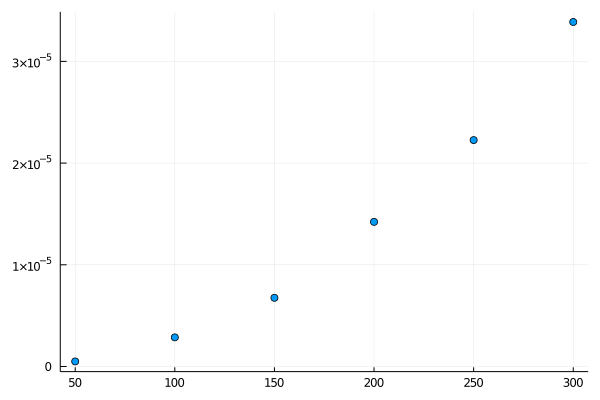

In [82]:
scatter(range,times[range],legend=false)

Although this looks quadratic, let's see if it is.  We can find the data to a quadratic using the following:

In [84]:
 model(t, p) = p[1].+p[2].*t.+p[3].*t.^2

model (generic function with 1 method)

In [85]:
fit = curve_fit(model, range, times[range], [1e-8,1e-8,1e-8]);

And if we want the parameters

In [86]:
fit.param

3-element Array{Float64,1}:
  6.3202917975684e-7
 -2.4225260649895998e-8
  4.48851805867244e-10

The following is the confidence intervals for each of the paramters. 

In [87]:
confidence_interval(fit, 0.05)

3-element Array{Tuple{Float64,Float64},1}:
 (-1.7556840562893979e-6, 3.019742415803078e-6)
 (-5.546740551854598e-8, 7.0168842187539865e-9)
 (3.6147044882083024e-10, 5.362331629136578e-10)

Because the first two contain 0, we don't include them and remodel using only the $t^2$ term: 

In [90]:
fit2 = curve_fit((t,p)->p[1].*t.^2,range,times[range],[1e-8]);

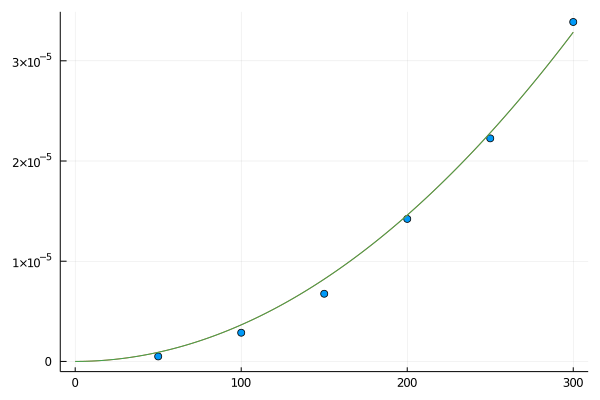

In [91]:
plot!(n->fit2.param[1]*n^2,0:300)

Next, we are going to do an alternative way of evaluating a polynomial.  This is called Horner's form. 

The polynomial

$$p(x) = a_0 + a_1 x + a_2 x^2 + a_3 x^3 + \cdots + a_n x^n$$

can be written:

$$(a_n x +a_{n-1})x + a_{n-2})x + \cdots + a_2)x^2 + a_1)x + a_0$$ 

and the result is that there are $n$ multiplications and $n$ additions. So this should be faster.

In [92]:
function horner(coeffs::Vector{T},x::S) where {T <: Number, S <: Number}
  result = coeffs[end] 
  for i=length(coeffs)-1:-1:1
    result = x*result+coeffs[i]
  end
  result
end

horner (generic function with 1 method)

In [93]:
htime = zeros(Float64,300)
for i=range
  coeffs = rand(Float64,i)
  htime[i] = @belapsed horner($coeffs,1/3)
end

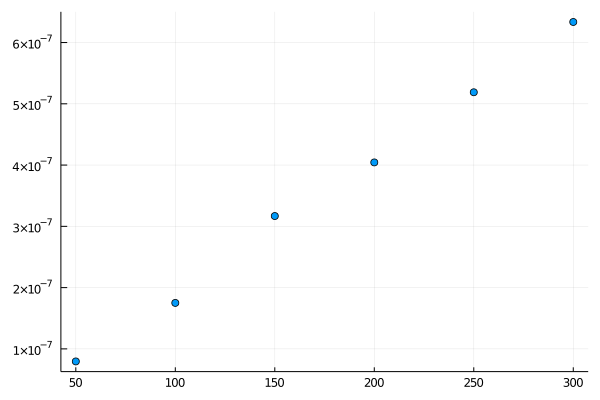

In [113]:
scatter(range,htime[range],legend=false)

In [114]:
fit3 = curve_fit(model, range, htime[range], [1e-8,1e-8,1e-8]);

In [115]:
fit3.param

3-element Array{Float64,1}:
 -3.6437552536251676e-8
  2.2554501886688914e-9
 -9.465005837300052e-14

In [116]:
confidence_interval(fit3)

3-element Array{Tuple{Float64,Float64},1}:
 (-1.1202488218245203e-7, 3.9149777109948677e-8)
 (1.2664242590093617e-9, 3.244476118328421e-9)
 (-2.8608630777121925e-12, 2.671562960966191e-12)

Only the 2nd parameter (the linear one) is significant so generate a new model with just that term:

In [117]:
fit4 = curve_fit((t,p)->p[1].*t,range,htime[range],[1e-8]);

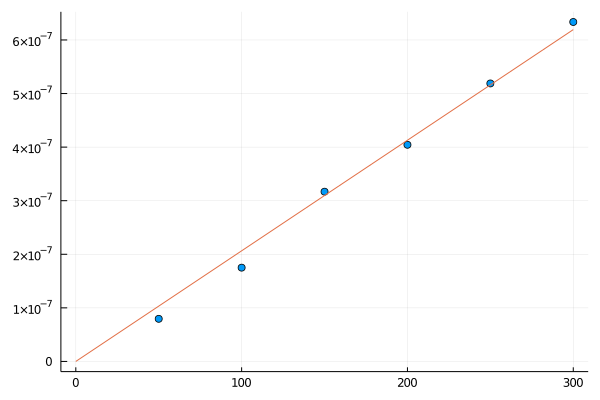

In [118]:
plot!(n->fit4.param[1]*n,0:300)

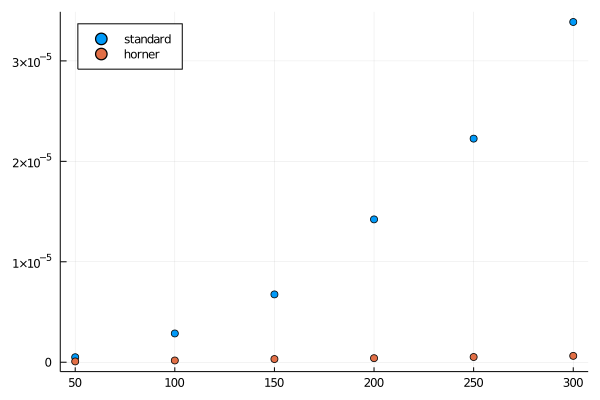

In [119]:
scatter(50:50:300,times[50:50:300],label="standard",legend=:topleft)
scatter!(50:50:300,htime[50:50:300],label="horner")

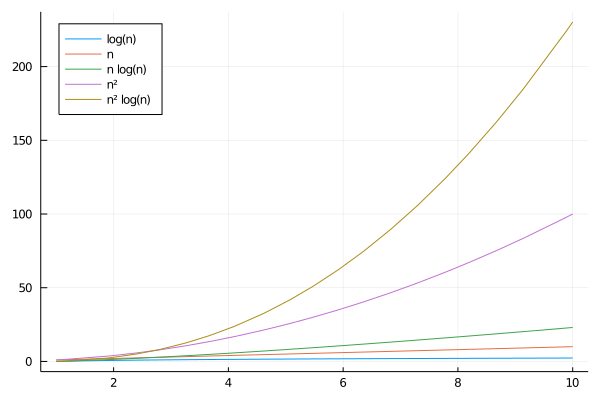

In [21]:
plot([x->log(x),x->x,x->x*log(x),x->x^2,x->x^2*log(x)],1,10,
    label=["log(n)" "n" "n log(n)"  "n²" "n² log(n)"],
    legend=:topleft)

### Testing the speed of Primes

From Chapter 8, we developed the following function that tests for being prime.  In this section, we will determine the order of this algorithm:

In [120]:
function isPrime5(n::Integer)
  if n%2==0
    return false
  end
  for k=3:2:round(Int,sqrt(n))
    if n%k==0
      return false
    end
  end
  true
end

isPrime5 (generic function with 1 method)

In [121]:
using Primes

The following generates an array of prime numbers and then times whether or not each is a prime number.

In [170]:
the_primes = map(nextprime,5_000_000:5_000_000:100_000_000)
prime_times=Float64[]
for p in the_primes
  push!(prime_times,@belapsed isPrime5($p))
end

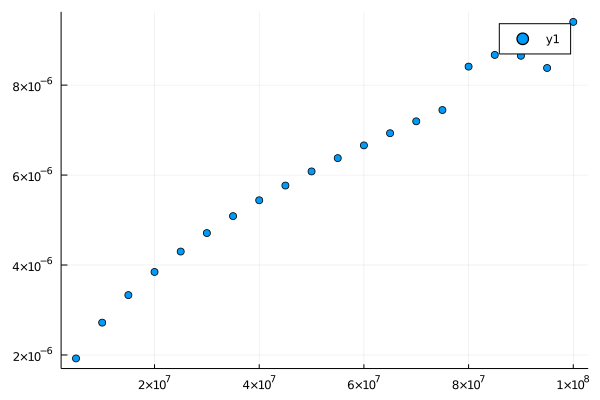

In [181]:
scatter(the_primes,prime_times)

Let's build a model with just a constant term, a square root and a log term based on the plot:

In [182]:
 model5(t, p) = p[1].+p[2].*sqrt.(t).+p[3]*log.(t)

model5 (generic function with 1 method)

In [183]:
fit5 = curve_fit(model5,the_primes, prime_times, [1e-4, 1e-4,1e-4]);

In [184]:
fit5.param

3-element Array{Float64,1}:
  9.212270217936757e-6
  1.1497961584901282e-9
 -6.312375833312806e-7

In [185]:
confidence_interval(fit5)

3-element Array{Tuple{Float64,Float64},1}:
 (-7.794794288787266e-7, 1.920401986475224e-5)
 (9.154115654970788e-10, 1.3841807514831775e-9)
 (-1.2906370572589192e-6, 2.816189059635803e-8)

Only the $\sqrt{n}$ term is significant.  Let's fit the model to just that one:

In [186]:
fit6 = curve_fit((t,p) -> p[1].*sqrt.(t),the_primes,prime_times,[1e-6]);

In [187]:
fit6.param

1-element Array{Float64,1}:
 8.846685353616923e-10

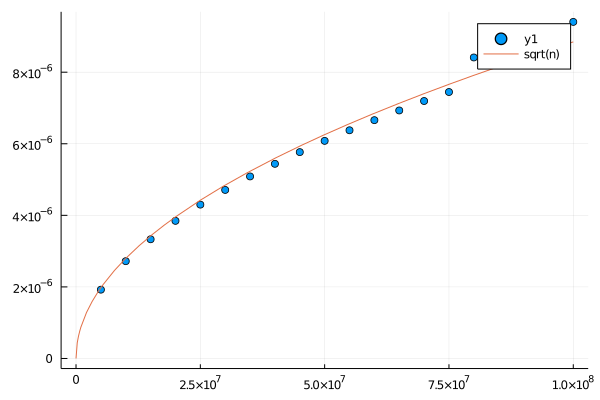

In [188]:
plot!(t->fit6.param[1]*sqrt(t),1,100_000_000,label="sqrt(n)")

This shows using some data that the order of operations (big-O) of finding prime numbers using this algorithm is $O(\sqrt{n})$